<a href="https://colab.research.google.com/github/Sathwika1103/Performance-analysis-of-GNN/blob/main/PageRank_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 80.2 MB/s eta 0:00:00


In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp

import dgl.data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = dgl.data.CoraGraphDataset()
g = dataset[0].to(device)

# Split edge set for training and testing
u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * 0.1)
train_size = g.number_of_edges() - test_size
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges and split them for training and testing
adj = sp.coo_matrix((np.ones(len(u)), (u.cpu().numpy(), v.cpu().numpy())))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]
train_g = dgl.remove_edges(g, eids[:test_size]).to(device)
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g.to(in_feat.device), in_feat)
        h = F.relu(h)
        h = self.conv2(g.to(h.device), h)
        return h



train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes()).to(device)

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes()).to(device)


class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, h_feats)
        self.W2 = nn.Linear(h_feats, 1)

    def apply_edges(self, edges):
        #Computes a scalar score for each edge of the given graph.
        h = torch.cat([edges.src['h'], edges.dst['h']], 1)
        h=h.to(self.W2.weight.device)
        return {'score': self.W2(F.relu(self.W1(h))).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h.to(g.device)
            g.apply_edges(self.apply_edges)
            return g.edata['score'].to(torch.device('cpu'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = GraphSAGE(train_g.ndata['feat'].shape[1], 16).to(device)
pred = MLPPredictor(16).to(device)

def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).to(device)
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)


def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).cpu().numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).cpu().numpy()
    return roc_auc_score(labels, scores)

optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

all_logits = []
for e in range(100):
    # forward
    h = model(train_g, train_g.ndata['feat'].to(device))
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss.to(torch.device('cpu'))))

from sklearn.metrics import roc_auc_score
with torch.no_grad():
    h = model(train_g, train_g.ndata['feat'].to(device))
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC', compute_auc(pos_score, neg_score))

    threshold = 0.5
    pos_pred = pos_score > threshold
    neg_pred = neg_score > threshold


    print("Some of the negative links predicted:")
    for i in range(10):
        print(f"Predicted link: {test_neg_u[i].item()} - {test_neg_v[i].item()}, Score: {neg_score[i].item()}, Prediction: {neg_pred[i].item()}")




  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


In epoch 0, loss: 0.6931350827217102
In epoch 5, loss: 0.6888157725334167
In epoch 10, loss: 0.6671745181083679
In epoch 15, loss: 0.6170991063117981
In epoch 20, loss: 0.5752643346786499
In epoch 25, loss: 0.5543788075447083
In epoch 30, loss: 0.5294675827026367
In epoch 35, loss: 0.5101289749145508
In epoch 40, loss: 0.4889347553253174
In epoch 45, loss: 0.46749094128608704
In epoch 50, loss: 0.4414888322353363
In epoch 55, loss: 0.4128722846508026
In epoch 60, loss: 0.3824138045310974
In epoch 65, loss: 0.34933289885520935
In epoch 70, loss: 0.31068655848503113
In epoch 75, loss: 0.26703354716300964
In epoch 80, loss: 0.2316124141216278
In epoch 85, loss: 0.20430752635002136
In epoch 90, loss: 0.1803092658519745
In epoch 95, loss: 0.16026760637760162
AUC 0.8423521484243389
Some of the negative links predicted:
Predicted link: 1337 - 567, Score: 3.261206865310669, Prediction: True
Predicted link: 2592 - 1030, Score: -12.353510856628418, Prediction: False
Predicted link: 298 - 225, Sc

/usr/local/lib/python3.9/dist-packages/dgl/backend/pytorch/tensor.py:445: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


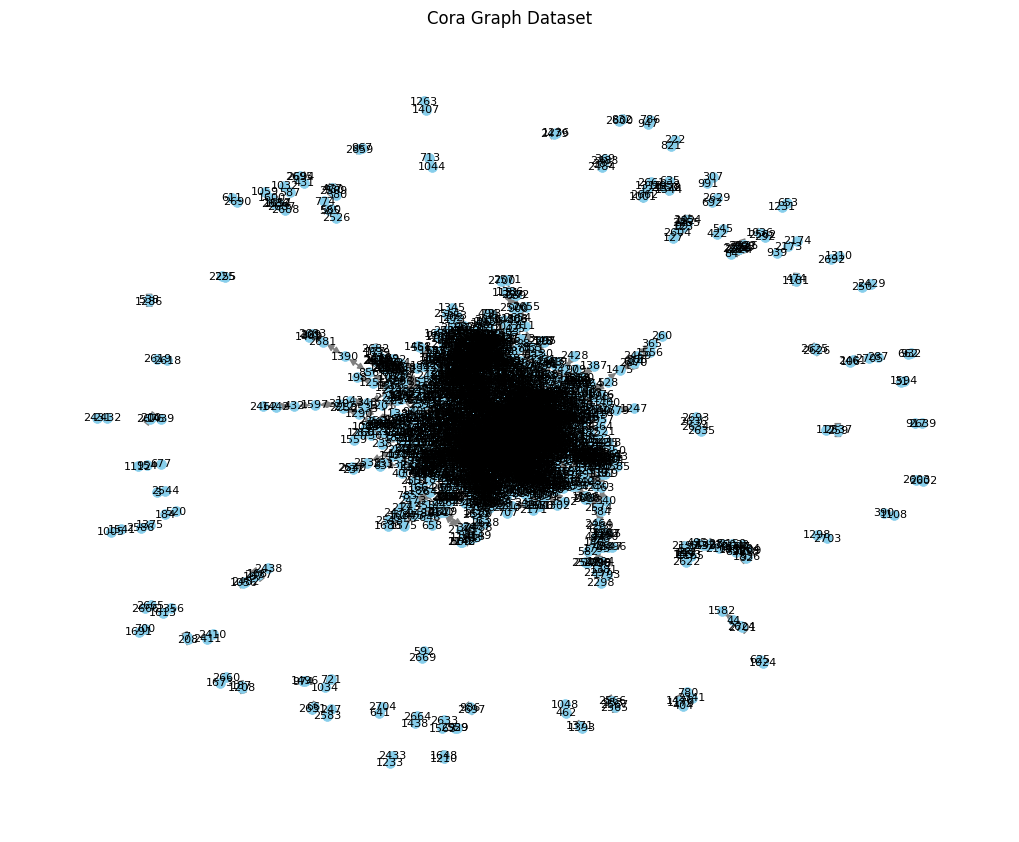

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import dgl.data

# Load the CoraGraphDataset
dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

# Convert DGLGraph to NetworkX graph
nx_g = g.to_networkx()

# Plot the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(nx_g, seed=42)
nx.draw(nx_g, pos, with_labels=True, node_size=50, font_size=8, font_color='black', node_color='skyblue', edge_color='gray', linewidths=0.5)
plt.title("Cora Graph Dataset")
plt.show()


In [ ]:
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
ERROR: Could not find a version that satisfies the requirement torch-scatter (from versions: none)
ERROR: No matching distribution found for torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
ERROR: Could not find a version that satisfies the requirement torch-sparse (from versions: none)
ERROR: No matching distribution found for torch-sparse
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
ERROR: Could not find a version that satisfies the requirement torch-cluster (from versions: none)
ERROR: No matching distribution found for torch-cluster
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
ERROR: Could not find a version that satisfies the requirement torch-spline-conv (from versions: none)
ERROR: No matching distribution found for torch-spline-conv
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops

# Define the GNN model
class GNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GNN, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Perform message passing using the adjacency matrix
        x = self.propagate(edge_index, x=x)

        # Apply linear transformation
        x = self.lin(x)

        return x

# Define the PageRankGNN model
class PageRankGNN(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(PageRankGNN, self).__init__(aggr='add')  # Use 'add' aggregation for messages
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Perform message passing and update node features
        x_prev = x.clone()  # Clone x for updating x_prev
        x = self.lin(x)
        x = self.propagate(edge_index, x=x, x_prev=x_prev)  # Update x_prev during message passing
        return x

    def message(self, x_j, x_prev_j):
        return torch.cat((x_j, x_prev_j), dim=-1)  # Concatenate x_j and x_prev_j

    def update(self, aggr_out):
        return aggr_out  # Identity update function

# Define the PageRank algorithm using the GNN model
class PageRank(torch.nn.Module):
    def __init__(self, in_channels, out_channels, alpha=0.85, tol=1e-6, max_iter=100):
        super(PageRank, self).__init__()
        self.gnn = GNN(in_channels, out_channels)
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter

    def forward(self, x, edge_index):
        return self.rank_nodes(x, edge_index)

    def rank_nodes(self, x, edge_index):
        x_init = x.clone()  # Create a copy of x as the initial node scores
        x_prev = x.clone()  # Create a copy of x as the previous node scores
        for _ in range(self.max_iter):
            x = self.gnn(x, edge_index)
            x = torch.cat((self.alpha * x, (1 - self.alpha) * x_init), dim=1)  # Concatenate along a new dimension
            if torch.norm(x[:, :x_prev.size(1)] - x_prev) < self.tol:  # Slice x to match the size of x_prev
                break
            x_prev = x
        return x

# Create the dataset and dataloader
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
loader = DataLoader([data], batch_size=1)

# Instantiate the PageRank algorithm
in_channels = data.num_features
out_channels = 64
model = GNN(in_channels, out_channels)

x = data.x
edge_index = data.edge_index
scores = model(x, edge_index)

print(scores)


Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


tensor([[ 0.1912, -0.2658, -0.1097,  ..., -0.1119,  0.0373, -0.0750],
        [-0.0146, -0.3326, -0.1248,  ..., -0.4044,  0.0647,  0.1994],
        [-0.0357, -0.3940, -0.1976,  ..., -0.2527,  0.0057, -0.0850],
        ...,
        [-0.0456, -0.0991,  0.0182,  ..., -0.0822,  0.0502, -0.1024],
        [ 0.0345,  0.0262,  0.1352,  ..., -0.0038, -0.0785, -0.0862],
        [ 0.1099, -0.0652,  0.0384,  ..., -0.0633, -0.1953, -0.0690]],
       grad_fn=<AddmmBackward0>)


In [ ]:
model = GNN(in_channels, out_channels)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training loop
model.train()
for epoch in range(100):
    for batch in loader:
        optimizer.zero_grad()
        x = batch.x
        edge_index = batch.edge_index
        y = batch.y
        scores = model(x, edge_index)
        loss = criterion(scores, y)
        loss.backward()
        optimizer.step()

    # Print loss for this epoch
    print('Epoch [{}/{}], with GNN Loss: {:.4f}'.format(epoch+1, 100, loss.item()))



Epoch [1/100], with GNN Loss: 4.1973
Epoch [2/100], with GNN Loss: 2.9167
Epoch [3/100], with GNN Loss: 2.1690
Epoch [4/100], with GNN Loss: 1.6962
Epoch [5/100], with GNN Loss: 1.3666
Epoch [6/100], with GNN Loss: 1.1257
Epoch [7/100], with GNN Loss: 0.9469
Epoch [8/100], with GNN Loss: 0.8128
Epoch [9/100], with GNN Loss: 0.7110
Epoch [10/100], with GNN Loss: 0.6325
Epoch [11/100], with GNN Loss: 0.5706
Epoch [12/100], with GNN Loss: 0.5209
Epoch [13/100], with GNN Loss: 0.4801
Epoch [14/100], with GNN Loss: 0.4459
Epoch [15/100], with GNN Loss: 0.4168
Epoch [16/100], with GNN Loss: 0.3918
Epoch [17/100], with GNN Loss: 0.3699
Epoch [18/100], with GNN Loss: 0.3506
Epoch [19/100], with GNN Loss: 0.3335
Epoch [20/100], with GNN Loss: 0.3180
Epoch [21/100], with GNN Loss: 0.3041
Epoch [22/100], with GNN Loss: 0.2914
Epoch [23/100], with GNN Loss: 0.2797
Epoch [24/100], with GNN Loss: 0.2689
Epoch [25/100], with GNN Loss: 0.2589
Epoch [26/100], with GNN Loss: 0.2496
Epoch [27/100], with 

In [ ]:
import networkx as nx
import torch

# Load the dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Convert the edge index to adjacency list
adj_list = {}
for i in range(data.edge_index.size(1)):
    src = data.edge_index[0, i].item()
    tgt = data.edge_index[1, i].item()
    if src not in adj_list:
        adj_list[src] = []
    adj_list[src].append(tgt)

# Convert adjacency list to NetworkX graph
G = nx.DiGraph(adj_list)

# Compute the PageRank scores
alpha = 0.85
max_iter = 10000
tol = 1e-6
pagerank = nx.pagerank(G, alpha=alpha, max_iter=max_iter, tol=tol)

pagerank_tensor = torch.tensor([pagerank[i] for i in range(data.num_nodes)])

# Compute the accuracy
threshold = np.median(pagerank_tensor.detach().numpy())  # Use median as threshold
predicted_labels = (pagerank_tensor > threshold).int()
accuracy = (predicted_labels == data.y).sum().item() / data.num_nodes

mse_loss = ((pagerank_tensor - data.y) ** 2).mean()

print(f"MSE Loss for standard Pagerank: {mse_loss:.4f}")

MSE Loss for standard Pagerank: 11.0751


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.optim import Adam
from torch_geometric.datasets import Planetoid
from sklearn.metrics import accuracy_score

# Load the dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Define the model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.fc = torch.nn.Linear(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

# Create the model and send it to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=0.01)

# Train the model

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x.to(device), data.edge_index.to(device))
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    out = model(data.x.to(device), data.edge_index.to(device))
    pred = out.argmax(dim=1)
    train_acc = accuracy_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu())
    val_acc = accuracy_score(data.y[data.val_mask].cpu(), pred[data.val_mask].cpu())
    print(f'Epoch: {epoch+1}, Loss without GNN: {loss:.4f}, Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}')




Epoch: 1, Loss without GNN: 1.9625, Train acc: 0.2143, Val acc: 0.1820
Epoch: 2, Loss without GNN: 1.9151, Train acc: 0.2786, Val acc: 0.2140
Epoch: 3, Loss without GNN: 1.8666, Train acc: 0.3786, Val acc: 0.2540
Epoch: 4, Loss without GNN: 1.8196, Train acc: 0.5643, Val acc: 0.3140
Epoch: 5, Loss without GNN: 1.7141, Train acc: 0.6643, Val acc: 0.3780
Epoch: 6, Loss without GNN: 1.6550, Train acc: 0.7857, Val acc: 0.4740
Epoch: 7, Loss without GNN: 1.5927, Train acc: 0.8429, Val acc: 0.5280
Epoch: 8, Loss without GNN: 1.4907, Train acc: 0.8929, Val acc: 0.5520
Epoch: 9, Loss without GNN: 1.4347, Train acc: 0.9214, Val acc: 0.5740
Epoch: 10, Loss without GNN: 1.3330, Train acc: 0.9429, Val acc: 0.6020
Epoch: 11, Loss without GNN: 1.2074, Train acc: 0.9929, Val acc: 0.6440
Epoch: 12, Loss without GNN: 1.1905, Train acc: 0.9929, Val acc: 0.6620
Epoch: 13, Loss without GNN: 1.1012, Train acc: 1.0000, Val acc: 0.6860
Epoch: 14, Loss without GNN: 1.0224, Train acc: 1.0000, Val acc: 0.6960
E